In [6]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List

# define the hyperparameters
batch_size = 32
block_size = 256
max_iters = 5000 # set the number of training iterations as you like
eval_interval = 50
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 96
n_heads = 8
n_layers = 6

In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import math


class char_tokenizer:
    """
    a very simple char-based tokenizer. the tokenizer turns a string into a list of integers.
    """

    def __init__(self, corpus: List[str]):
        self.corpus = corpus
        # TODO: calculate the vocab size and create a dictionary that maps each character to a unique integer
        self.n_vocab = len(corpus)
        self.char_to_int = {char: i for i, char in enumerate(corpus)}
        self.int_to_char = {i: char for char, i in self.char_to_int.items()}
        # End of your code

    def encode(self, string: str):
        # TODO: convert a string into a list of integers and return, using the dictionary you created above
        return [self.char_to_int[char] for char in string]
        # End of your code
 
    def decode(self, codes: List[int]):
        # TODO: convert a list of integers into a string and return, using the dictionary you created above
        return ''.join([self.int_to_char[code] for code in codes])
        # End of your code

class Head(nn.Module):
    """single head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        # TODO: create three linear layers, Key, Query, and Value, each of which maps from n_embd to head_size
        #       and assign them to self.Key, self.Query, and self.Value, respectively
        self.Key = nn.Linear(n_embd, head_size)
        self.Query = nn.Linear(n_embd, head_size)
        self.Value = nn.Linear(n_embd, head_size)
        # End of your code
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, inputs):
        # TODO: implement the forward function of the head
        #       the input is a tensor of shape (batch, time, n_embd)
        #       the output should be a tensor of shape (batch, time, head_size)
        #       you may use the tril buffer defined above to mask out the upper triangular part of the affinity matrix
        # Apply linear transformations to obtain Key, Query, and Value
        # print(f"inputs shape: {inputs.shape}")
        
        batch_size, time, n_embd = inputs.shape

        keys = self.Key(inputs)
        queries = self.Query(inputs)
        values = self.Value(inputs)
        
        # Calculate attention scores
        attention_scores = torch.matmul(queries, keys.transpose(-1, -2))
        # print(f"queries shape: {queries.shape}")
        # print(attention_scores.shape)
        attention_scores = attention_scores / math.sqrt(keys.size(-1))

        # Apply masking to attention scores
        attention_scores = attention_scores.masked_fill(self.tril[:time, :time] == 0, float('-inf'))

        # Apply softmax activation to obtain attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply attention weights to values
        # print(f"attention_weights shape: {attention_weights.shape}")
        # print(f"values shape: {values.shape}")
        out = torch.matmul(attention_weights, values)

        # End of your code
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        #TODO: implement heads and projection
        self.n_heads = n_heads
        self.head_size = head_size

        # Create individual heads
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])

        # Linear projection layer
        self.projection = nn.Linear(n_heads * head_size, n_embd)

        # End of your code
    def forward(self, inputs):
        #TODO: implement the forward function of the multi-head attention
        # Split inputs into multiple heads
        head_outputs = [head(inputs) for head in self.heads]

        # Concatenate head outputs along the head dimension
        out = torch.cat(head_outputs, dim=-1)

        # Apply linear projection to obtain the final output
        return self.projection(out)


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        #TODO: implement the feed-forward network

        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

        # End of your code

    def forward(self, inputs):
        return self.net(inputs)


class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        # TODO: implement the block of transformer using the MultiHeadAttention and 
        # FeedForward modules, along with the layer normalization layers

        # Multi-head attention layer
        self.attention = MultiHeadAttention(n_heads, n_embd // n_heads)

        # Layer normalization layers
        self.norm1 = nn.LayerNorm(n_embd)
        self.norm2 = nn.LayerNorm(n_embd)

        # Feed-forward network
        self.feed_forward = FeedForward(n_embd)

        # End of your code
    def forward(self, inputs):
        #TODO: implement the forward function of the block, you may refer to the docs of this experiment

        # Apply layer normalization to the inputs
        norm_inputs = self.norm1(inputs)

        # Perform multi-head attention
        attention_out = self.attention(norm_inputs)

        # Add residual connection and apply layer normalization
        attention_out = norm_inputs + attention_out
        norm_attention_out = self.norm2(attention_out)

        # Apply feed-forward network
        ff_out = self.feed_forward(norm_attention_out)

        # Add residual connection
        out = norm_attention_out + ff_out

        # End of your code
        return out
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        self.d_model = d_model

        # Create position encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add position embeddings to the input
        x = x + self.pe[:, :x.size(1)]
        return x


class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: create the embedding table, the stack of blocks, the layer normalization layer, 
        # and the linear layers.

        # Embedding table
        self.embedding = nn.Embedding(n_vocab, n_embd)
        self.positional_encoding = PositionalEncoding(n_embd, block_size)

        # Stack of transformer blocks
        self.blocks = nn.ModuleList([
            Block(n_embd, n_heads) for _ in range(n_layers)
        ])

        # Layer normalization layer
        self.norm = nn.LayerNorm(n_embd)

        # Linear layer for output projection
        self.linear = nn.Linear(n_embd, n_vocab)

        # End of your code

    def forward(self, inputs, labels=None):
        # TODO: implement the forward function of the transformer

        # inputs:(batch, context)
        # batch, time, channel = inputs.shape
        # embedding:(batch, context, embedding)

        # attens:(batch, context, embedding)

        # attens:(batch, context, embedding)

        # logits:(batch, context, attens)

        # End of your code

        # compute the loss
        # Embedding inputs
        embedded_inputs = self.embedding(inputs)
        encoded_inputs = self.positional_encoding(embedded_inputs)
        # print(f"embedded_inputs shape: {embedded_inputs.shape}")

        # Apply transformer blocks
        out = encoded_inputs
        for block in self.blocks:
            out = block(out)

        # Apply layer normalization
        out = self.norm(out)

        # Linear projection
        logits = self.linear(out)
        if labels is None:
            loss = None
        else:
            batch, time, channel = logits.shape
            logits = logits.view(batch * time, channel)
            labels = labels.view(batch * time)
            loss = F.cross_entropy(logits, labels)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        # TODO: generate new tokens from the transformer, using the inputs as the context,
        #  and return the generated tokens with length of max_new_tokens

        for _ in range(max_new_tokens):
            # generates new tokens by iteratively sampling from the model's predicted probability distribution, 
            # concatenating the sampled tokens to the input sequence, and returning the updated sequence.

            # truncate
            inputs = inputs[:, -block_size:]
            logits, _ = self.forward(inputs)
            probabilities = F.softmax(logits[:, -1], dim=-1)
            sampled_token = torch.multinomial(probabilities, num_samples=1)
            inputs = torch.cat([inputs, sampled_token], dim=1)
        # End of your code
        return inputs


def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[k] = loss.sum().item()
        out[split] = losses.mean()
    return out


def generate(model, context, max_new_tokens):
    # context = torch.zeros((1, 1), device=device, dtype=torch.long)
    # str1 = "The meaning of life is "
    # context = torch.tensor([tokenizer.encode(str1)], device=device, dtype=torch.long)
    print(decode(model.generate(context, max_new_tokens=max_new_tokens)[0].tolist()))


def train(model):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    for iter in range(max_iters):
        
        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            print(
                f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )
            train_losses.append(losses["train"])
            val_losses.append(losses["val"])

        inputs, labels = get_batch("train")

        logits, loss = model(inputs, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.sum().backward()
        optimizer.step()
    return train_losses, val_losses


In [9]:
# read the dataset
with open("../data/input.txt", "r", encoding="utf-8") as f:
    text = f.read()
chars = sorted(list(set(text)))

# initialize the vocabulary
tokenizer = char_tokenizer(chars)
encode = tokenizer.encode
decode = tokenizer.decode
n_vocab = tokenizer.n_vocab

# separate the dataset into train and validation
train_data = torch.tensor(encode(text[: -len(text) // 10]), dtype=torch.long)
val_data = torch.tensor(encode(text[-len(text) // 10 :]), dtype=torch.long)

# define the model
model = Transformer().to(device)
train_losses, val_losses = train(model)
# generate(model)


step 0: train loss 4.3378, val loss 4.3304
step 50: train loss 2.5728, val loss 2.5837
step 100: train loss 2.4997, val loss 2.5083
step 150: train loss 2.4556, val loss 2.4724
step 200: train loss 2.4041, val loss 2.4179
step 250: train loss 2.3246, val loss 2.3438
step 300: train loss 2.2392, val loss 2.2701
step 350: train loss 2.1762, val loss 2.2132
step 400: train loss 2.0987, val loss 2.1568
step 450: train loss 2.0254, val loss 2.1087
step 500: train loss 1.9697, val loss 2.0577
step 550: train loss 1.9173, val loss 2.0049
step 600: train loss 1.8579, val loss 1.9730
step 650: train loss 1.8204, val loss 1.9425
step 700: train loss 1.7848, val loss 1.9237
step 750: train loss 1.7480, val loss 1.8888
step 800: train loss 1.7129, val loss 1.8821
step 850: train loss 1.6946, val loss 1.8504
step 900: train loss 1.6720, val loss 1.8402
step 950: train loss 1.6385, val loss 1.8054
step 1000: train loss 1.6226, val loss 1.7971
step 1050: train loss 1.6055, val loss 1.7939
step 1100: 

In [9]:
# PB20111689 蓝俊玮
str1 = "caixukun I love "
context = torch.tensor([tokenizer.encode(str1)], device=device, dtype=torch.long)
generate(model, context=context, max_new_tokens=128)

caixukun I love him Edward?

VOLUMNIA:
I hope, that we do
Than this ance doth have I on here with thee!
This an other Earl shut the king blunty,


In [19]:
import matplotlib.pyplot as plt
def show_process(train_loss, valid_loss):
    plt.plot(train_loss, label="Train Loss")
    plt.plot(valid_loss, label="Valid Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Binary Entropy Loss")
    plt.legend(loc='upper right')
    plt.title("Loss Curve by PB20111689")
    plt.show()

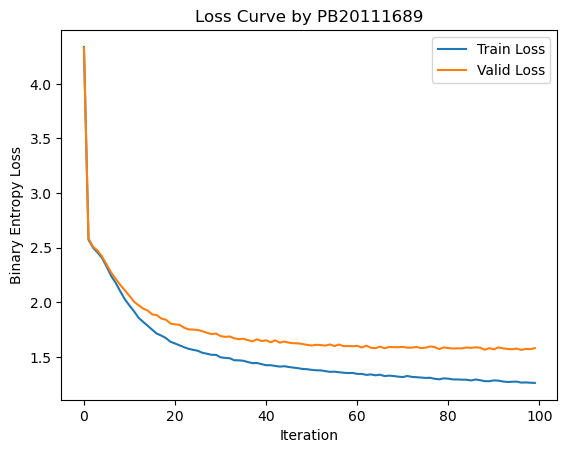

In [20]:
show_process(train_losses, val_losses)

In [18]:
# PB20111689 蓝俊玮
str2 = "Hefei is a great "
context = torch.tensor([tokenizer.encode(str2)], device=device, dtype=torch.long)
generate(model, context=context, max_new_tokens=128)

Hefei is a great think,
Such by that, to foreign out the poor drink.
The indeed-golder of thy lost house is king,
And that shall bear this this b
